<a href="https://colab.research.google.com/github/SayatAbdikul/animal_classification_model/blob/main/animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [137]:
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
folder_path = '/content/drive/My Drive/animal_images'
dataset = ImageFolder(root=folder_path, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [138]:
dataset.classes

['Abyssinian',
 'Bengal',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound']

In [139]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

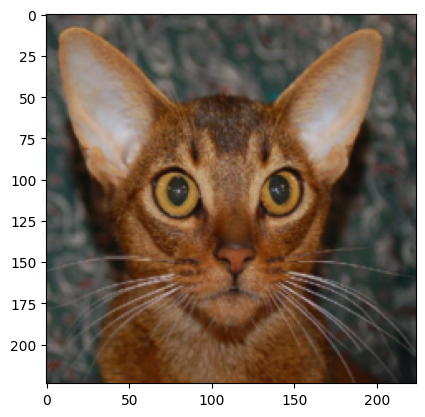

In [140]:
import matplotlib.pyplot as plt
image = next(iter(train_dataloader))[0][0]
to_pil = transforms.ToPILImage()
plt.imshow(to_pil(image))
plt.show()

# Helper functions

In [141]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [142]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if len(X) == 0:
            print(f"empty batch on {batch}")
            continue
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 5 == 0:
          print(f"looked at batch: {batch}/ {len(dataloader)}")
    print(f"Train loss: {train_loss/len(train_dataloader):.5f} | Train accuracy: {train_acc/len(train_dataloader):.2f}%")

In [143]:
def validation_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> float:
    model.eval()
    with torch.inference_mode():
        val_loss, val_acc = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            if len(X) == 0:
                print(f"empty batch on {batch}")
                continue
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        print(f"Validation loss: {val_loss/len(val_dataloader):.5f} | Validation acc: {val_acc/len(val_dataloader):.2f}%")

# Baseline model


In [150]:
from torch import nn

class BaselineModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [155]:
model_0 = BaselineModel(input_shape=3*image_size*image_size, hidden_units=10, output_shape=5)
model_0

BaselineModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=5, bias=True)
    (6): ReLU()
  )
)

In [156]:
torch.manual_seed(7)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_0.to(device)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_0, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    validation_step(model=model_0, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------
looked at batch: 0/ 27
looked at batch: 5/ 27
looked at batch: 10/ 27
looked at batch: 15/ 27
looked at batch: 20/ 27
looked at batch: 25/ 27
Train loss: 2.19066 | Train accuracy: 26.22%
Validation loss: 1.57346 | Validation acc: 36.21%
Epoch: 1
---------
looked at batch: 0/ 27
looked at batch: 5/ 27
looked at batch: 10/ 27
looked at batch: 15/ 27
looked at batch: 20/ 27
looked at batch: 25/ 27
Train loss: 1.56963 | Train accuracy: 33.97%
Validation loss: 1.55089 | Validation acc: 36.21%
Epoch: 2
---------
looked at batch: 0/ 27
looked at batch: 5/ 27
looked at batch: 10/ 27
looked at batch: 15/ 27
looked at batch: 20/ 27
looked at batch: 25/ 27
Train loss: 1.56045 | Train accuracy: 33.91%
Validation loss: 1.54492 | Validation acc: 36.21%
